In [1]:
%env MUJOCO_GL=egl
import mujoco
import gymnasium as gym
from stable_baselines3 import DDPG
from stable_baselines3.common.env_util import make_vec_env
import stable_baselines3.common.noise as sb3_noise
import mediapy as media
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R
import os

env: MUJOCO_GL=egl


In [316]:
model = mujoco.MjModel.from_xml_path("models/bitcraze_crazyflie_2/cf2mod.xml")
data = mujoco.MjData(model)

""

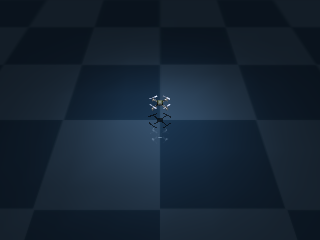

In [8]:
with mujoco.Renderer(model) as renderer:
    mujoco.mj_forward(model, data)
    renderer.update_scene(data)
    media.show_image(renderer.render())

In [9]:
def enforce_motor_limits(motor_commands):
    motor_commands = np.array(motor_commands)
    motor_commands[:3] *= 1e1  # correct for scaling in the model
    motor_commands = np.clip(motor_commands, [-0.007, -0.007, -0.007, 0], [0.007, 0.007, 0.007, 0.35])
    return motor_commands

def feedback_control(data):
    kp = 3.0
    kd = 1.0
    pos_desired = np.array([0.0, 0.0, 0.05])
    vel_desired = np.array([0.0, 0.0, 0.0])
    
    pos_error = pos_desired - data.qpos[0:3]
    vel_error = vel_desired - data.qvel[0:3]
    
    m = model.body('cf2').mass[0]
    force = kp * pos_error + kd * vel_error + np.array([0.0, 0.0, 9.81])
    thrust = m * force[2]

    return enforce_motor_limits([0, 0, 0, thrust])

def c_controller(data, desired_pos=[0.0, 0.0, 0.05]):
    p_x_des, p_y_des, p_z_des = desired_pos
    
    p_x, p_y, p_z = data.qpos[0:3]
    v_x, v_y, v_z = data.qvel[0:3]
    w_x, w_y, w_z = data.qvel[3:6]
    # w_x, w_y, w_z = data.sensor('body_gyro').data  # use gyro readings for angular velocity
    
    phi, theta, psi = R.from_quat(data.qpos[3:7], scalar_first=True).as_euler('xyz')
    # theta *= -1  # correct for different coordinate system
    
    tau_x = 0.00491541 * (p_y - p_y_des) -0.00652343 * phi + 0.00264962 * v_y -0.00084121 * w_x
    tau_y = -0.00491541 * (p_x - p_x_des) -0.00654763 * theta -0.00265419 * v_x -0.00084713 * w_y
    tau_z = -0.00010906 * psi -0.00009983 * w_z
    # f_z = -0.17624202 * (p_z - p_z_des) -0.10988951 * v_z + 0.32373000
    f_z = -0.17624202 * (p_z - p_z_des) -0.10988951 * v_z + model.body('cf2').mass[0] * 9.81
    
    return enforce_motor_limits([tau_x, tau_y, tau_z, f_z])
    
    # m_1 = -4676393.6 * tau_x -4676393.6 * tau_y -78864353.3 * tau_z + 154321.0 * f_z
    # m_2 = -4676393.6 * tau_x + 4676393.6 * tau_y + 78864353.3 * tau_z + 154321.0 * f_z
    # m_3 = 4676393.6 * tau_x + 4676393.6 * tau_y -78864353.3 * tau_z + 154321.0 * f_z
    # m_4 = 4676393.6 * tau_x -4676393.6 * tau_y + 78864353.3 * tau_z + 154321.0 * f_z
    
    # motor_commands = np.array([m_1, m_2, m_3, m_4])
    # motor_commands = np.clip(motor_commands, 0, 65535)

def perturb_initial_state(data):
    # data.qpos[0:3] += np.random.uniform(-0.001, 0.001, size=3)
    # data.qvel[0:3] += np.random.uniform(-0.001, 0.001, size=3)
    # data.qvel[3:6] += np.random.uniform(-0.001, 0.001, size=3)
    # perturb orientation by small random angles
    angles = np.random.uniform(-0.001, 0.001, size=3)
    rot = R.from_euler('xyz', angles)
    current_rot = R.from_quat(data.qpos[3:7], scalar_first=True)
    new_rot = rot * current_rot
    data.qpos[3:7] = new_rot.as_quat(scalar_first=True)

In [10]:
duration = 20  # (seconds)
framerate = 60  # (Hz)

desired_pos = np.array([0.0, 0.0, 0.5])

# Simulate and display video.
frames = []
t_l = []
qpos_l = []
qori_l = []
u_l = []
mujoco.mj_resetData(model, data)  # Reset state and time.
# perturb_initial_state(data)
with mujoco.Renderer(model, height=480, width=640) as renderer:
    while data.time < duration:
        # u = feedback_control(data)
        u = c_controller(data, desired_pos=desired_pos)
        # u = np.zeros(4)
        data.actuator('x_moment').ctrl = u[0]
        data.actuator('y_moment').ctrl = u[1]
        data.actuator('z_moment').ctrl = u[2]
        data.actuator('body_thrust').ctrl = u[3]
        

        mujoco.mj_step(model, data)
        if len(frames) < data.time * framerate:
            t_l.append(data.time)
            u_l.append(u)
            qpos_l.append(data.qpos.copy())
            qori_l.append(R.from_quat(data.qpos[3:7], scalar_first=True).as_euler('xyz'))
            
            renderer.update_scene(data, camera='track')
            pixels = renderer.render()
            frames.append(pixels)

t_l = np.array(t_l)
qpos_l = np.array(qpos_l)
qori_l = np.array(qori_l)
u_l = np.array(u_l)
media.show_video(frames, fps=framerate)

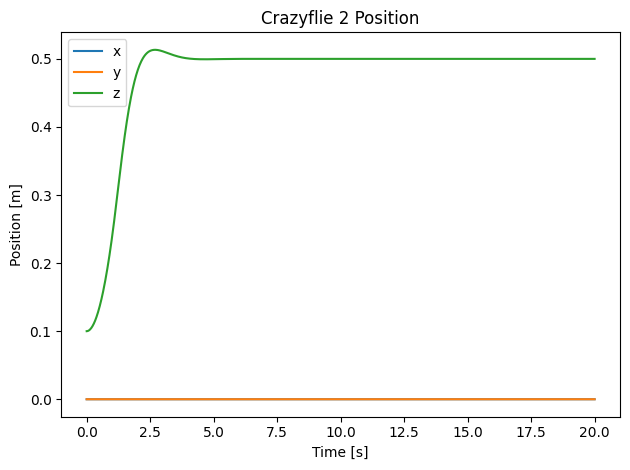

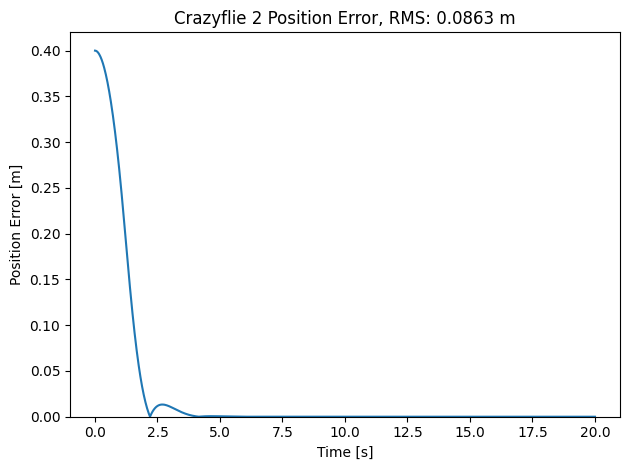

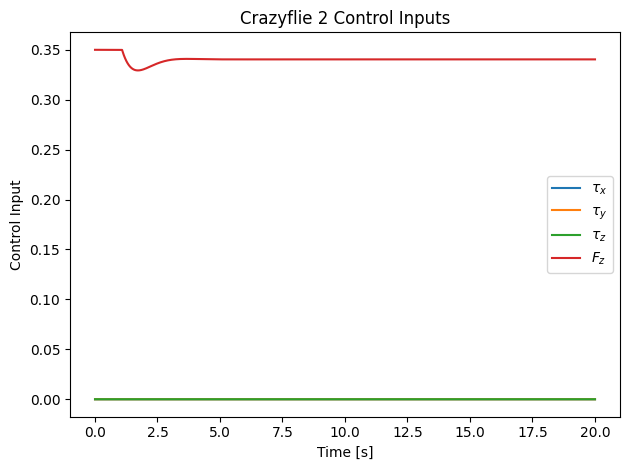

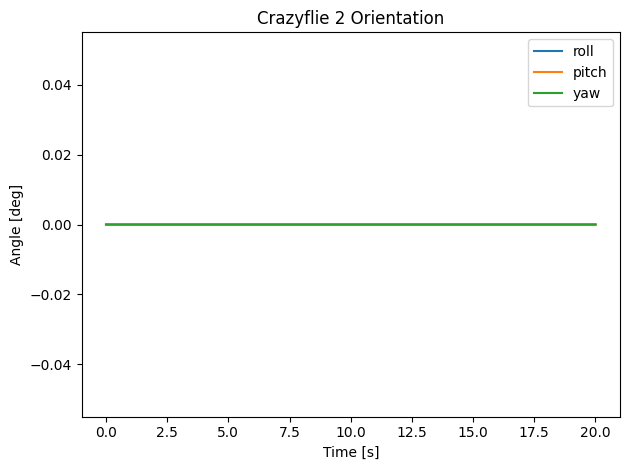

In [77]:
plt.plot(t_l, qpos_l[:, 0], label="x")
plt.plot(t_l, qpos_l[:, 1], label="y")
plt.plot(t_l, qpos_l[:, 2], label="z")
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.legend()
plt.title("Crazyflie 2 Position")
plt.tight_layout()
plt.show()

error_norm = np.linalg.norm(qpos_l[:, :3] - desired_pos, axis=1)
rms_error = np.sqrt(np.mean(error_norm**2))
plt.plot(t_l, error_norm)
plt.xlabel("Time [s]")
plt.ylabel("Position Error [m]")
plt.title(f"Crazyflie 2 Position Error, RMS: {rms_error:.4f} m")
# set y lower limit to 0
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

plt.plot(t_l, u_l[:, 0], label=r"$\tau_x$")
plt.plot(t_l, u_l[:, 1], label=r"$\tau_y$")
plt.plot(t_l, u_l[:, 2], label=r"$\tau_z$")
plt.plot(t_l, u_l[:, 3], label=r"$F_z$")
plt.xlabel("Time [s]")
plt.ylabel("Control Input")
plt.legend()
plt.title("Crazyflie 2 Control Inputs")
plt.tight_layout()
plt.show()

plt.plot(t_l, np.degrees(qori_l[:, 0]), label="roll")
plt.plot(t_l, np.degrees(qori_l[:, 1]), label="pitch")
plt.plot(t_l, np.degrees(qori_l[:, 2]), label="yaw")
plt.xlabel("Time [s]")
plt.ylabel("Angle [deg]")
plt.legend()
plt.title("Crazyflie 2 Orientation")
plt.tight_layout()
plt.show()

In [19]:
class Control:
    def __init__(self):
        self.thrustSi = 0
        self.torqueX = 0
        self.torqueY = 0
        self.torqueZ = 0

    def __repr__(self):
        return f"Control(tx = {self.torqueX:.3E}; ty = {self.torqueY:.3E}; tz = {self.torqueZ:.3E}; fz = {self.thrustSi:.3E})"

    def to_array(self):
        return np.array([self.torqueX, self.torqueY, self.torqueZ, self.thrustSi])

def feedforwardController(currentTime: float, control: Control):
    if currentTime < 0.5:
        control.thrustSi = 0.35
        control.torqueX = 0
        control.torqueY = 0
        control.torqueZ = 0
    else:
        control.thrustSi = 0
        control.torqueX = 0
        control.torqueY = 0
        control.torqueZ = 0

In [230]:
class SimResult:
    def __init__(self, duration=20, framerate=60):
        self.duration = duration
        self.framerate = framerate
        self.time = []
        self.pos = []
        self.ori = []
        self.quat = []
        self.u = []
        self.frames = []

    def log(self, data, control, frame=None):
        self.time.append(data.time)
        self.u.append(control.to_array())
        self.pos.append(data.qpos.copy())
        self.quat.append(data.qpos[3:7])
        self.ori.append(R.from_quat(data.qpos[3:7], scalar_first=True).as_euler('xyz'))

        if frame is not None:
            self.frames.append(frame)

    def convert_to_arrays(self):
        self.time = np.asarray(self.time)
        self.pos = np.asarray(self.pos)
        self.ori = np.asarray(self.ori)
        self.quat = np.asarray(self.quat)
        self.u = np.asarray(self.u)

    def show_video(self):
        if self.frames != []:
            media.show_video(self.frames, fps=self.framerate)

    def plot_results(self):
        self.convert_to_arrays()
        plt.plot(self.time, self.pos[:, 0], label="x")
        plt.plot(self.time, self.pos[:, 1], label="y")
        plt.plot(self.time, self.pos[:, 2], label="z")
        plt.minorticks_on()
        plt.xlabel("Time [s]")
        plt.ylabel("Position [m]")
        plt.legend()
        plt.title("Crazyflie 2 Position")
        plt.xlim([0, self.duration])
        plt.tight_layout()
        plt.show()
        
        plt.plot(self.time, self.u[:, 3], label=r"$F_z$", color='red')
        plt.minorticks_on()
        plt.xlabel("Time [s]")
        plt.ylabel("Body Thrust [N]")
        plt.legend(loc='upper left')

        ax2 = plt.gca().twinx()
        ax2.plot(self.time, self.u[:, 0], label=r"$\tau_x$", color='blue')
        ax2.plot(self.time, self.u[:, 1], label=r"$\tau_y$", color='blue', linestyle='--')
        ax2.plot(self.time, self.u[:, 2], label=r"$\tau_z$", color='blue', linestyle='-.')
        ax2.set_ylabel('Torque [Nm]')
        
        plt.legend(loc='upper right')
        plt.title("Crazyflie 2 Control Inputs")
        plt.xlim([0, self.duration])
        plt.tight_layout()
        plt.show()
        
        plt.plot(self.time, np.degrees(self.ori[:, 0]), label="roll")
        plt.plot(self.time, np.degrees(self.ori[:, 1]), label="pitch")
        plt.plot(self.time, np.degrees(self.ori[:, 2]), label="yaw")
        plt.minorticks_on()
        plt.xlabel("Time [s]")
        plt.ylabel("Angle [deg]")
        plt.legend()
        plt.title("Crazyflie 2 Orientation")
        plt.xlim([0, self.duration])
        plt.tight_layout()
        plt.show()

def simController(controller, duration=20, framerate=60, make_frames=True):
    control = Control()
    res = SimResult(duration, framerate)
    framecount = 0

    mujoco.mj_resetData(model, data)  # Reset state and time.
    data.qpos[2] = 0
    # perturb_initial_state(data)
    with mujoco.Renderer(model, height=480, width=640) as renderer:
        while data.time < duration:
            t = data.time
            # update control
            controller(t, control)

            # allocate control
            data.actuator('x_moment').ctrl = control.torqueX
            data.actuator('y_moment').ctrl = control.torqueY
            data.actuator('z_moment').ctrl = control.torqueZ
            data.actuator('body_thrust').ctrl = control.thrustSi
    
            mujoco.mj_step(model, data)
            if framecount < data.time * framerate:
                frame = None
                framecount += 1
                
                if make_frames:
                    renderer.update_scene(data, camera='track')
                    frame = renderer.render()

                res.log(data, control, frame)
    
    res.convert_to_arrays()

    return res
    

In [231]:
M = model.body('cf2').mass[0]
g = 9.80665

In [232]:
np.sqrt(2)/2 + 0.25

np.float64(0.9571067811865476)

In [250]:
def feedforwardController(currentTime: float, control: Control):
    ascentTime = 2.5
    rollTime = 0.165
    rollTorque = 0.7e-3
    thrustCompFactor = 0.96



    rollManeuverTime = rollTime + 2*rollTime + rollTime
    
    if currentTime < ascentTime:
        control.thrustSi = 0.35
    elif currentTime < 2*ascentTime:
        control.thrustSi = (1 + 1/thrustCompFactor)*M*g - 0.35
    elif currentTime < 2*ascentTime + rollManeuverTime:
        control.thrustSi = 1/thrustCompFactor*M*g
    elif currentTime < 10:
        control.thrustSi = 0.35
        control.torqueX = 0

    # ROLL+
    #                               start roll-up
    if currentTime < ascentTime:
        control.torqueX = 0
    elif currentTime < ascentTime + rollTime:
        # control.thrustSi = (1 + 1/thrustCompFactor)*M*g - 0.35
        control.torqueX = rollTorque
    #                                          start roll-down
    elif currentTime < ascentTime + rollTime + 2*rollTime:
        # control.thrustSi = (1 + 1/thrustCompFactor)*M*g - 0.35
        control.torqueX = -rollTorque
    #                                                       halt roll
    elif currentTime < ascentTime + rollTime + 2*rollTime + rollTime:
        # control.thrustSi = (1 + 1/thrustCompFactor)*M*g - 0.35
        control.torqueX = rollTorque
    elif currentTime < 2*ascentTime:
        # control.thrustSi = (1 + 1/thrustCompFactor)*M*g - 0.35
        control.torqueX = 0

    # ROLL-
    #                                 start roll-up
    elif currentTime < 2*ascentTime + rollTime:
        # control.thrustSi = 1/thrustCompFactor*M*g
        control.torqueX = -rollTorque
    #                                            start roll-down
    elif currentTime < 2*ascentTime + rollTime + 2*rollTime:
        # control.thrustSi = 1/thrustCompFactor*M*g
        control.torqueX = rollTorque
    #                                                         halt roll
    elif currentTime < 2*ascentTime + rollTime + 2*rollTime + rollTime:
        # control.thrustSi = 1/thrustCompFactor*M*g
        control.torqueX = -rollTorque

    # ROLL+
    #                                                    start roll-up
    elif currentTime < 2*ascentTime + rollManeuverTime + rollTime:
        control.thrustSi = 1/thrustCompFactor*M*g
        control.torqueX = rollTorque
    #                                                               start roll-down
    elif currentTime < 2*ascentTime + rollManeuverTime + rollTime + 2*rollTime:
        control.thrustSi = 1/thrustCompFactor*M*g
        control.torqueX = -rollTorque
    #                                                                            halt roll
    elif currentTime < 2*ascentTime + rollManeuverTime + rollTime + 2*rollTime + rollTime:
        control.thrustSi = 1/thrustCompFactor*M*g
        control.torqueX = rollTorque
    
    elif currentTime < 10:
        control.thrustSi = M*g

        
    # elif currentTime < 2:
    #     control.thrustSi = 0.2
    #     control.torqueX = -0.7e-3
    # elif currentTime < 2.2:
    #     control.thrustSi = 0
    #     control.torqueX = 0
    else:
        control.thrustSi = 0
        control.torqueX = 0
        control.torqueY = 0
        control.torqueZ = 0
        
res = simController(feedforwardController, duration=10)

In [317]:
def feedforwardController(currentTime: float, control: Control):
    ascentTime = 3
    rollTime = 0.165
    rollTorque = 0.7e-3
    thrustCompFactor = 0.96



    rollManeuverTime = rollTime + 2*rollTime + rollTime
    
    if currentTime < ascentTime:
        control.thrustSi = 0.35
    # elif currentTime < ascentTime + 3*rollManeuverTime:
    #     control.thrustSi = (1 + 1/thrustCompFactor)*M*g - 0.35
    # elif currentTime < 2*ascentTime:
    #     control.thrustSi = 1/thrustCompFactor*M*g
    elif currentTime < ascentTime + 2*rollManeuverTime:
        control.thrustSi = 1/thrustCompFactor*M*g
    elif currentTime < 8:
        control.thrustSi = M*g
        control.torqueX = 0
    else:
        control.thrustSi = 0
        control.torqueX = 0

    # ROLL+
    #                               start roll-up
    if currentTime < ascentTime:
        control.torqueX = 0
    elif currentTime < ascentTime + rollTime:
        control.torqueX = rollTorque
    #                                          start roll-down
    elif currentTime < ascentTime + rollTime + 2*rollTime:
        control.torqueX = -rollTorque
    #                                                       halt roll
    elif currentTime < ascentTime + rollTime + 2*rollTime + rollTime:
        control.torqueX = rollTorque
        
    # ROLL-
    #                                 start roll-up
    elif currentTime < ascentTime + rollManeuverTime + rollTime:
        # control.thrustSi = 1/thrustCompFactor*M*g
        control.torqueX = -rollTorque
    #                                            start roll-down
    elif currentTime < ascentTime + rollManeuverTime + rollTime + 2*rollTime:
        # control.thrustSi = 1/thrustCompFactor*M*g
        control.torqueX = rollTorque
    #                                                         halt roll
    elif currentTime < ascentTime + rollManeuverTime + rollTime + 2*rollTime + rollTime:
        # control.thrustSi = 1/thrustCompFactor*M*g
        control.torqueX = -rollTorque

    # # ROLL+
    # #                                                    start roll-up
    # elif currentTime < ascentTime + 2*rollManeuverTime + rollTime:
    #     # control.thrustSi = 1/thrustCompFactor*M*g
    #     control.torqueX = rollTorque
    # #                                                               start roll-down
    # elif currentTime < ascentTime + 2*rollManeuverTime + rollTime + 2*rollTime:
    #     # control.thrustSi = 1/thrustCompFactor*M*g
    #     control.torqueX = -rollTorque
    # #                                                                            halt roll
    # elif currentTime < ascentTime + 2*rollManeuverTime + rollTime + 2*rollTime + rollTime:
    #     # control.thrustSi = 1/thrustCompFactor*M*g
    #     control.torqueX = rollTorque
    
    # elif currentTime < 10:
    #     control.thrustSi = M*g

        
    # # elif currentTime < 2:
    # #     control.thrustSi = 0.2
    # #     control.torqueX = -0.7e-3
    # # elif currentTime < 2.2:
    # #     control.thrustSi = 0
    # #     control.torqueX = 0
    # else:
    #     control.thrustSi = 0
    #     control.torqueX = 0
    #     control.torqueY = 0
    #     control.torqueZ = 0
        
res = simController(feedforwardController, duration=10)

In [318]:
res.show_video()

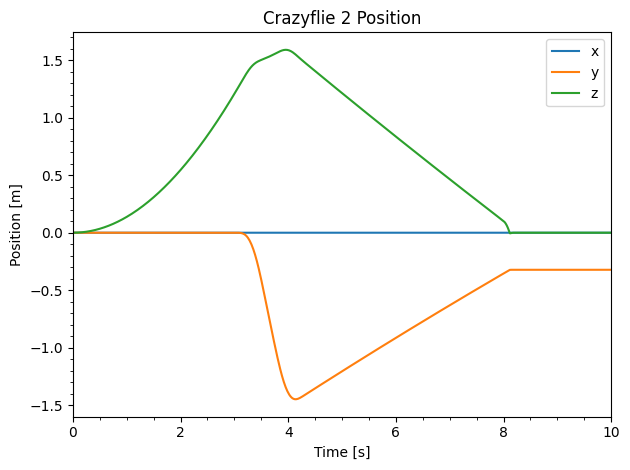

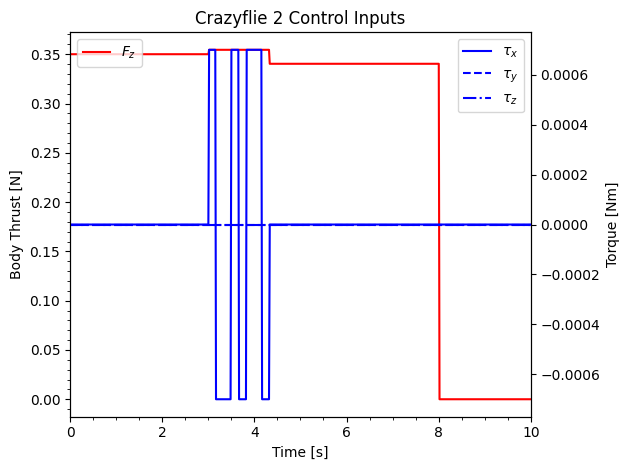

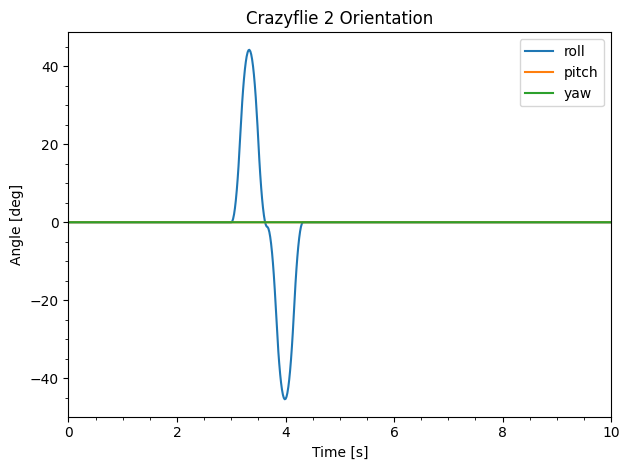

In [319]:
res.plot_results()

In [312]:
np.degrees(np.max(res.ori[:,0]))

np.float64(44.27074767919204)

In [186]:
control = Control()
feedforwardController(0, control)
control

Control(tx = 0.000E+00; ty = 0.000E+00; tz = 0.000E+00; fz = 3.500E-01)

In [8]:
def backflip_reference(t, start_pos=[0.0, 0.0, 0.5], flip_height=1.0, duration=2.0):
    """Compute backflip reference position and orientation at time t.
    
    Args:
        t: float, time in seconds
        start_pos: list of 3 floats, starting position [x, y, z]
        flip_height: float, maximum height of the flip
        duration: float, total duration of the flip in seconds
    
    Returns:
        position: np.ndarray of shape (3,)
        orientation: np.ndarray of shape (3,) in radians (roll, pitch, yaw)
    """
    if t < 0 or t > duration:
        return np.array(start_pos), np.array([0.0, 0.0, 0.0])
    
    # Vertical position follows a parabolic trajectory
    if t <= duration / 2:
        z = start_pos[2] + (4 * flip_height / duration**2) * t * (duration / 2 - t)
    else:
        z = start_pos[2]
    
    position = np.array([start_pos[0], start_pos[1], z])
    
    # Pitch angle follows a linear trajectory from 0 to 360 degrees
    pitch = (360.0 / duration) * t
    orientation = np.array([0.0, np.radians(pitch), 0.0])  # roll=0, yaw=0
    
    return position, orientation

def backflip_reference_trajectory(start_pos=[0.0, 0.0, 0.5], flip_height=1.0, duration=2.0, dt=1/60):
    """Generate a backflip reference trajectory.
    
    Returns:
        times: np.ndarray of shape (N,)
        positions: np.ndarray of shape (N, 3)
        orientations: np.ndarray of shape (N, 3)
    """
    
    num_steps = int(duration / dt)
    positions = np.zeros((num_steps, 3))
    orientations = np.zeros((num_steps, 3))  # roll, pitch, yaw
    times = np.linspace(0, duration, num_steps)
        
    for i, t in enumerate(times):
        pos, ori = backflip_reference(t, start_pos=start_pos, flip_height=flip_height, duration=duration)
        positions[i] = pos
        orientations[i] = ori

    return times, positions, orientations

In [9]:
def backflip_reference(t, start_pos=[0.0, 0.0, 0.5], flip_height=1.0, duration=2.0):
    """Compute backflip reference position and orientation at time t.
    
    Args:
        t: float, time in seconds
        start_pos: list of 3 floats, starting position [x, y, z]
        flip_height: float, maximum height of the flip
        duration: float, total duration of the flip in seconds
    
    Returns:
        position: np.ndarray of shape (3,)
        orientation: np.ndarray of shape (3,) in radians (roll, pitch, yaw)
    """
    if t < 0 or t > duration:
        return np.array(start_pos), np.array([0.0, 0.0, 0.0])
    
    # Vertical position follows a parabolic trajectory
    if t <= duration / 2:
        z = start_pos[2] + (4 * flip_height / duration**2) * t * (duration / 2 - t)
    else:
        z = start_pos[2]
    
    position = np.array([start_pos[0], start_pos[1], z])
    
    # Pitch angle follows a linear trajectory from 0 to 360 degrees
    pitch = (360.0 / duration) * t
    orientation = np.array([0.0, np.radians(pitch), 0.0])  # roll=0, yaw=0
    
    return position, orientation

In [10]:
def reference_state(t, duration=10):
    pos = np.asarray([0, 0, 0.5])
    ori = np.asarray([0, (np.pi/4)*np.sin(t*2*np.pi/duration), 0])

    return pos, ori

def reference_trajectory(duration=10, dt=1/60):
    num_steps = int(duration / dt)
    positions = np.zeros((num_steps, 3))
    orientations = np.zeros((num_steps, 3))  # roll, pitch, yaw
    times = np.linspace(0, duration, num_steps)
        
    for i, t in enumerate(times):
        pos, ori = reference_state(t)
        positions[i] = pos
        orientations[i] = ori

    return times, positions, orientations

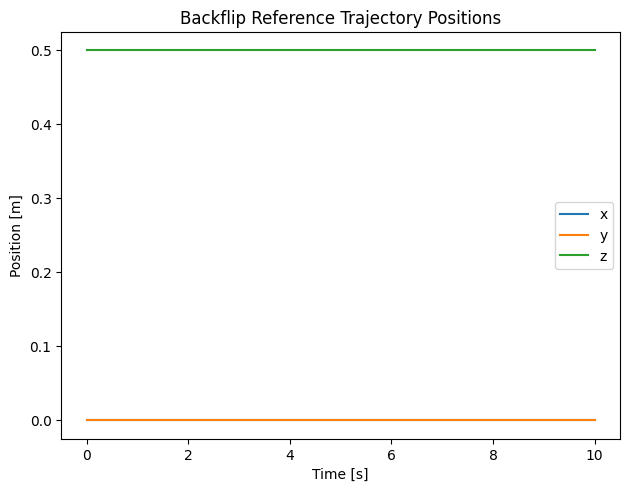

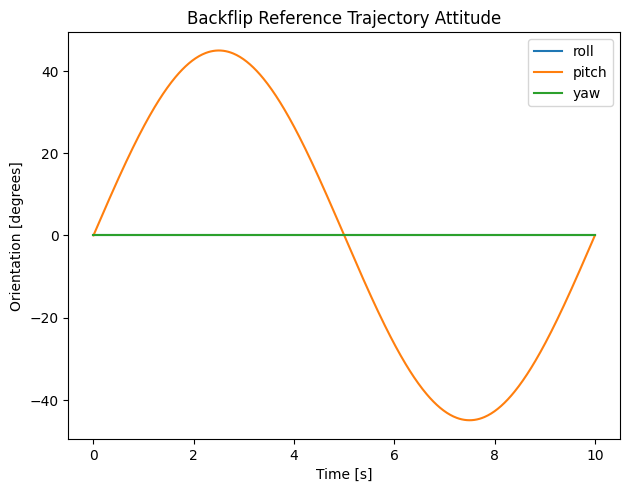

In [11]:
ref_traj = reference_trajectory(duration=10.0)
times, positions, orientations = ref_traj

plt.plot(times, positions[:, 0], label="x")
plt.plot(times, positions[:, 1], label="y")
plt.plot(times, positions[:, 2], label="z")
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.legend()
plt.tight_layout()
plt.title("Backflip Reference Trajectory Positions")
plt.show()

plt.plot(times, np.degrees(orientations[:, 0]), label="roll")
plt.plot(times, np.degrees(orientations[:, 1]), label="pitch")
plt.plot(times, np.degrees(orientations[:, 2]), label="yaw")
plt.xlabel("Time [s]")
plt.ylabel("Orientation [degrees]")
plt.legend()
plt.tight_layout()
plt.title("Backflip Reference Trajectory Attitude")
plt.show()

In [37]:
model.body('cf2').mass[0] * 9.81

np.float64(0.340407)

In [47]:
class BackflipEnv(gym.Env):
    action_space = gym.spaces.Box(low=np.array([-1, -1, -1, 0]), high=np.array([1, 1, 1, 0.5]), shape=(4,), dtype=np.float32)
        
    obs_low = np.array([-np.inf]*12, dtype=np.float32)
    obs_low[2] = 0.0  # z position must be non-negative
    obs_low[6:9] = -np.pi  # roll, pitch, yaw
    obs_low = obs_low.astype(np.float32)
    obs_high = np.array([np.inf]*12)
    obs_high[6:9] = np.pi  # roll, pitch, yaw
    obs_high = obs_high.astype(np.float32)
    observation_space = gym.spaces.Box(low=obs_low, high=obs_high, shape=(12,), dtype=np.float32)
    
    def __init__(self, start_position=[0.0, 0.0, 0.5], duration=10.0, flip_duration=4.0, dt=1/60, perturb_initial=False):
        super(BackflipEnv, self).__init__()
        self.duration = duration
        self.flip_duration = flip_duration
        self.dt = dt
        self.model = mujoco.MjModel.from_xml_path("models/bitcraze_crazyflie_2/cf2mod.xml")
        self.data = mujoco.MjData(self.model)
        self.current_step = 0
        self.num_steps = int(self.duration / self.dt)
        self.data.qpos[0:3] = np.array(start_position)
        self.start_pos = self.data.qpos[0:3].copy()
        
        self.perturb_initial = perturb_initial
        if self.perturb_initial:
            self.perturb_initial_state()
            
        mujoco.mj_forward(self.model, self.data)
        
    def render(self, mode='human'):
        with mujoco.Renderer(self.model, height=480, width=640) as renderer:
            renderer.update_scene(self.data, camera='track')
            pixels = renderer.render()
            return pixels
            
    def reset(self, *, seed = None, options = None):
        super().reset(seed=seed)
        mujoco.mj_resetData(self.model, self.data)
        self.data.qpos[0:3] = self.start_pos.copy()
        if self.perturb_initial:
            self.perturb_initial_state()
        self.current_step = 0
        return self.get_state(), {}

    def step(self, action):
        action = enforce_motor_limits(action)
        self.data.actuator('x_moment').ctrl = action[0]
        self.data.actuator('y_moment').ctrl = action[1]
        self.data.actuator('z_moment').ctrl = action[2]
        self.data.actuator('body_thrust').ctrl = action[3]
        
        while self.data.time < (self.current_step + 1) * self.dt:
            mujoco.mj_step(self.model, self.data)

        self.current_step += 1
        
        state = self.get_state()
        reward = self.compute_reward(action)
        terminated = self.current_step >= self.num_steps
        truncated = self.has_crashed()
        if truncated:
            reward -= 50
        
        return state, reward, terminated, truncated, {}
    
    def has_crashed(self):
        return self.data.qpos[2] < 0.01
            
    def get_state(self):
        pos = self.data.qpos[0:3].copy()
        ori = R.from_quat(self.data.qpos[3:7], scalar_first=True).as_euler('xyz')
        vel = self.data.qvel[0:3].copy()
        ang_vel = self.data.qvel[3:6].copy()
        return np.concatenate([pos, ori, vel, ang_vel])
            
    def get_reference(self, t):
        # pos, ori = backflip_reference(t, start_pos=self.start_pos, flip_height=1.0, duration=self.flip_duration)
        pos, ori = reference_state(t)
        return pos, ori
    
    def get_tracking_error(self):
        t = self.current_step * self.dt
        ref_pos, ref_ori = self.get_reference(t)
        current_pos = self.data.qpos[0:3]
        current_ori = R.from_quat(self.data.qpos[3:7], scalar_first=True).as_euler('xyz')
        
        pos_error = np.linalg.norm(current_pos[2] - ref_pos[2])**2
        ori_error = np.linalg.norm(current_ori - ref_ori)**2
        pitch_error = (current_ori[1] - ref_ori[1])**2
        
        return pos_error, ori_error, pitch_error
    
    def compute_reward(self, action=None):
        pos_error, ori_error, pitch_error = self.get_tracking_error()
        reward = 0
        reward -= 30*pos_error 
        reward -= 7*ori_error
        reward -= 10*pitch_error
        reward += self.current_step * 1e-2
        reward -= 0.1*np.linalg.norm(action)**2
        return reward
            
    def perturb_initial_state(self):
        angles = np.random.uniform(-0.001, 0.001, size=3)
        rot = R.from_euler('xyz', angles)
        current_rot = R.from_quat(self.data.qpos[3:7], scalar_first=True)
        new_rot = rot * current_rot
        self.data.qpos[3:7] = new_rot.as_quat(scalar_first=True)

In [69]:
class BackflipEnv(gym.Env):
    action_space = gym.spaces.Box(low=np.array([-1, 0.340407-0.1]), high=np.array([1, 0.340407+0.1]), shape=(2,), dtype=np.float32)
        
    obs_low = np.array([-np.inf]*12 + [0], dtype=np.float32)
    obs_low[2] = 0.0  # z position must be non-negative
    obs_low[6:9] = -np.pi  # roll, pitch, yaw
    obs_low = obs_low.astype(np.float32)
    obs_high = np.array([np.inf]*12 + [np.inf], dtype=np.float32)
    obs_high[6:9] = np.pi  # roll, pitch, yaw
    obs_high = obs_high.astype(np.float32)
    observation_space = gym.spaces.Box(low=obs_low, high=obs_high, shape=(13,), dtype=np.float32)
    
    def __init__(self, start_position=[0.0, 0.0, 0.5], duration=10.0, flip_duration=4.0, dt=1/60, perturb_initial=False):
        super(BackflipEnv, self).__init__()
        self.duration = duration
        self.flip_duration = flip_duration
        self.dt = dt
        self.model = mujoco.MjModel.from_xml_path("models/bitcraze_crazyflie_2/cf2mod.xml")
        self.data = mujoco.MjData(self.model)
        self.current_step = 0
        self.num_steps = int(self.duration / self.dt)
        self.data.qpos[0:3] = np.array(start_position)
        self.start_pos = self.data.qpos[0:3].copy()
        
        self.perturb_initial = perturb_initial
        if self.perturb_initial:
            self.perturb_initial_state()
            
        mujoco.mj_forward(self.model, self.data)
        
    def render(self, mode='human'):
        with mujoco.Renderer(self.model, height=480, width=640) as renderer:
            renderer.update_scene(self.data, camera='track')
            pixels = renderer.render()
            return pixels
            
    def reset(self, *, seed = None, options = None):
        super().reset(seed=seed)
        mujoco.mj_resetData(self.model, self.data)
        self.data.qpos[0:3] = self.start_pos.copy()
        if self.perturb_initial:
            self.perturb_initial_state()
        self.current_step = 0
        return self.get_state(), {}

    def step(self, action):
        action = enforce_motor_limits(np.array([0, action[0], 0, action[1]]))
        self.data.actuator('x_moment').ctrl = action[0]
        self.data.actuator('y_moment').ctrl = action[1]
        self.data.actuator('z_moment').ctrl = action[2]
        self.data.actuator('body_thrust').ctrl = action[3]
        
        while self.data.time < (self.current_step + 1) * self.dt:
            mujoco.mj_step(self.model, self.data)

        self.current_step += 1
        
        state = self.get_state()
        reward = self.compute_reward(action)
        terminated = self.current_step >= self.num_steps
        truncated = self.has_crashed()
        if truncated:
            reward -= 500
        
        return state, reward, terminated, truncated, {}
    
    def has_crashed(self):
        return self.data.qpos[2] < 0.05
            
    def get_state(self):
        pos = self.data.qpos[0:3].copy()
        ori = R.from_quat(self.data.qpos[3:7], scalar_first=True).as_euler('xyz')
        vel = self.data.qvel[0:3].copy()
        ang_vel = self.data.qvel[3:6].copy()
        return np.concatenate([pos, ori, vel, ang_vel, np.array([self.current_step * self.dt])])
            
    def get_reference(self, t):
        # pos, ori = backflip_reference(t, start_pos=self.start_pos, flip_height=1.0, duration=self.flip_duration)
        pos, ori = reference_state(t)
        return pos, ori
    
    def get_tracking_error(self):
        t = self.current_step * self.dt
        ref_pos, ref_ori = self.get_reference(t)
        current_pos = self.data.qpos[0:3]
        current_ori = R.from_quat(self.data.qpos[3:7], scalar_first=True).as_euler('xyz')
        
        pos_error = np.linalg.norm(current_pos - ref_pos)**2
        ori_error = np.linalg.norm(current_ori - ref_ori)**2
        pitch_error = np.linalg.norm(current_ori - ref_ori)**2
        z_error = (current_ori[2] - ref_ori[2])**2
        
        return pos_error, ori_error, pitch_error, z_error
    
    def compute_reward(self, action=None):
        pos_error, ori_error, pitch_error, z_error = self.get_tracking_error()
        reward = 0
        reward -= 10*pos_error 
        reward -= 30*z_error 
        reward -= 7*ori_error
        reward -= 30*pitch_error
        reward += self.current_step * 1e-2
        reward -= 0.1*np.linalg.norm(action)**2
        return reward
            
    def perturb_initial_state(self):
        angles = np.random.uniform(-0.001, 0.001, size=3)
        rot = R.from_euler('xyz', angles)
        current_rot = R.from_quat(self.data.qpos[3:7], scalar_first=True)
        new_rot = rot * current_rot
        self.data.qpos[3:7] = new_rot.as_quat(scalar_first=True)

In [65]:
from sb3_contrib.trpo.trpo import TRPO

In [70]:
env = make_vec_env(BackflipEnv, n_envs=8)
# env = BackflipEnv(perturb_initial=False)
policy = TRPO(
    "MlpPolicy",
    env,
    verbose=0,
    batch_size=512,
    # action_noise=sb3_noise.NormalActionNoise(np.zeros(4), np.array([1e-2, 1e-2, 1e-2, 1e-3])),
    tensorboard_log="./logs/ddpg_backflip/"
)
policy.learn(total_timesteps=1000000)

# vec_env = ddpg.get_env()
# obs = vec_env.reset()
# vec_env.render_mode = 'human'
# frames = []
# for _ in range(1000):
#     action, _states = ddpg.predict(obs, deterministic=True)
#     obs, reward, done, info = vec_env.step(action)
#     frame = vec_env.render(mode='human')
#     frames.append(frame)
    
env.close()

In [71]:
env = BackflipEnv(perturb_initial=False)
env.render_mode = 'human'

# vec_env = ddpg.get_env()
# obs = vec_env.reset()
vec_env = BackflipEnv(perturb_initial=False)
obs, _ = vec_env.reset()
vec_env.render_mode = 'human'
frames = []
actions = []
states = []
times = np.arange(vec_env.num_steps) / 60.
# for _ in range(1000):
for _ in range(vec_env.num_steps):
    action, _states = policy.predict(obs, deterministic=True)
    actions.append(action)
    obs, reward, done, truncated, info = vec_env.step(action)
    states.append(obs)
    frame = vec_env.render(mode='human')
    frames.append(frame)
    
env.close()
media.show_video(frames, fps=framerate)

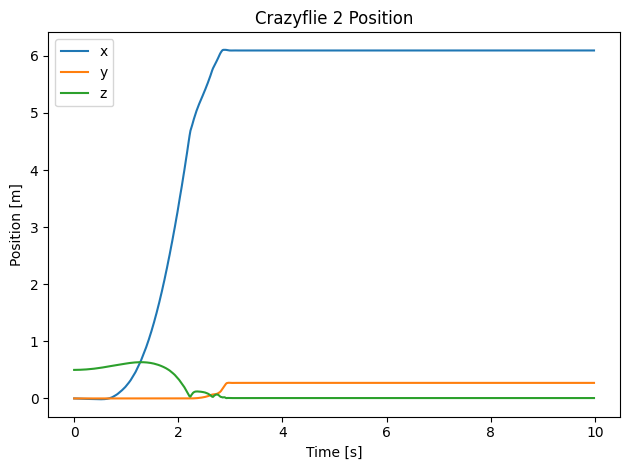

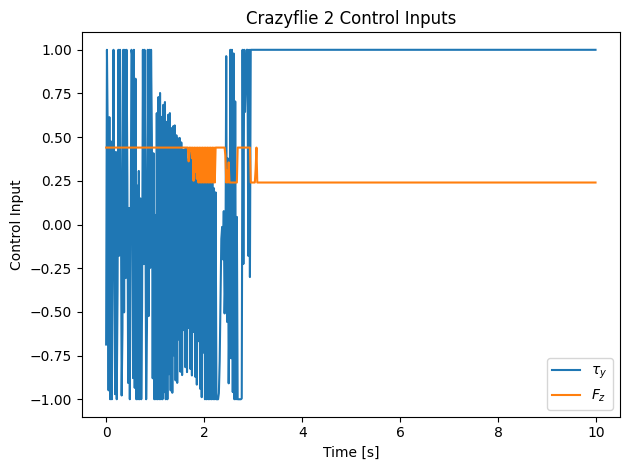

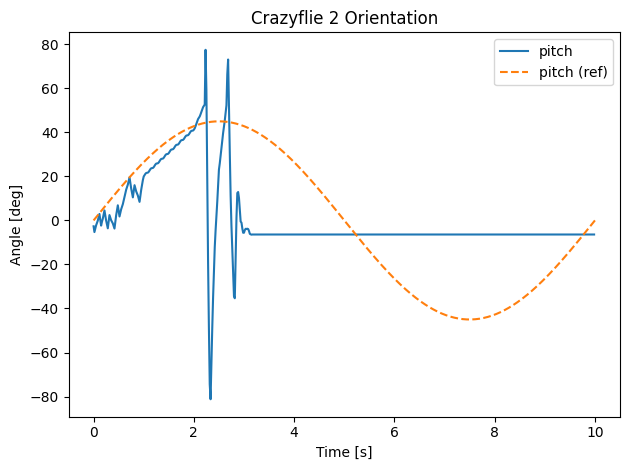

In [72]:
t_l = times
states = np.asarray(states)
actions = np.asarray(actions)
    
plt.plot(t_l, states[:, 0], label="x")
plt.plot(t_l, states[:, 1], label="y")
plt.plot(t_l, states[:, 2], label="z")
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.legend()
plt.title("Crazyflie 2 Position")
plt.tight_layout()
plt.show()

# error_norm = np.linalg.norm(states[:, :3] - desired_pos, axis=1)
# rms_error = np.sqrt(np.mean(error_norm**2))
# plt.plot(t_l, error_norm)
# plt.xlabel("Time [s]")
# plt.ylabel("Position Error [m]")
# plt.title(f"Crazyflie 2 Position Error, RMS: {rms_error:.4f} m")
# # set y lower limit to 0
# plt.ylim(bottom=0)
# plt.tight_layout()
# plt.show()

plt.plot(t_l, actions[:, 0], label=r"$\tau_y$")
plt.plot(t_l, actions[:, 1], label=r"$F_z$")
plt.xlabel("Time [s]")
plt.ylabel("Control Input")
plt.legend()
plt.title("Crazyflie 2 Control Inputs")
plt.tight_layout()
plt.show()

# plt.plot(t_l, np.degrees(states[:, 3]), label="roll")
plt.plot(t_l, np.degrees(states[:, 4]), label="pitch")
tref_l, pos_ref, ori_ref = reference_trajectory(duration=10.0)
plt.plot(tref_l, np.degrees(ori_ref[:, 1]), label="pitch (ref)", linestyle='--')
# plt.plot(t_l, np.degrees(states[:, 5]), label="yaw")
plt.xlabel("Time [s]")
plt.ylabel("Angle [deg]")
plt.legend()
plt.title("Crazyflie 2 Orientation")
plt.tight_layout()
plt.show()